## Decisions logic

Game choice logic:
- Somewhat nieche games with an assumed older audience, so reviews will be more constructive and 
  objective as oposed to having jokes or other off topic content;
- A decent number of reviews and a good balance between positive and negative with little varience overtime.

|      GAME       |  APPID  | POSITIVE REVIEWS | NEGATIVE REVIEWS | PERCENT | TOTAL |
|      :---       |   ---:  |      :---:       |       :---:      |  :---:  | :---: |
| F1 Manager 2024 | 2591280 |       1652       |        830       |   65%   | 2482  |
| Trials Fusion   |  245490 |       1550       |        734       |   66%   | 2284  |

As of 2024/10/12, no filters

---

How does Steam rating work?

<img src="./image/steam-rating.png" width="540px" height="540px" alt="A table with how steam reviews ratings labeling problably translate to recommended percentage">

---

Why leave the filter_offtopic_activity on:  
From [Steam docs](https://partner.steamgames.com/doc/store/reviews#ReviewBombing) on "Review Bombing":

> In all examples, the surge of volume and sentiment will calm down after a few days.
> The reviews during that period will be bucketed by Steam and identified as such by your customers.
> In the case of **off-topic bombs, those reviews will not contribute to your overall score**.
>
> The majority of reviews associated with bombs aren't typically marked as helpful.
> Once the campaign is over, it's less likely that they will be surfaced in your review feed.
> *We also haven't seen a correlation between review bombs and purchasing behavior.*


## Imports and downloads


In [3]:
import datetime
import glob
import io
import logging
import re
import urllib.parse
from string import punctuation
from typing import Any

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
import streamlit as st
import seaborn as sns
from cloudpickle import dump as cloudpickle_dump
from cloudpickle import load as cloudpickle_load
from matplotlib.gridspec import GridSpec
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.util import is_cjk
from rich import print as rprint
from rich.logging import RichHandler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.calibration import CalibrationDisplay
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    RocCurveDisplay,
    accuracy_score,
    auc,
    brier_score_loss,
    class_likelihood_ratios,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud


In [4]:
_ = nltk.download("punkt_tab")
_ = nltk.download("wordnet")
display(_,clear=True)

True

## Logger and misc

In [5]:
LOG_LEVEL = logging.INFO
logger: logging.Logger = logging.getLogger(__name__)
logger.addHandler(RichHandler(rich_tracebacks=True))
logger.setLevel(LOG_LEVEL)

pd.options.styler.format.precision = 3

## Game Class

In [6]:
class Game:
    """
    A class for working with Steam reviews.

    Attributes:
        name (str): The name of the game.
        appid (str): The Steam App ID of the game.
        params (dict[str, str]): The parameters for the Steam API call, in sorted order.
        cursor (dict[str, str]): The cursor parameter, as a dict.
        url (str): The URL for the Steam API call, with the parameters encoded in sorted order, excluding the cursor.
    """

    _root_url: str = "https://store.steampowered.com/appreviews/"

    _base_params: dict[str, str] = {
        "filter": "updated",  # all (default), recent, updated. all always returns --> can return duplicates
        "language": "english",  # english, brazilian, all ...
        # "day_range": "365",  # range from now to n days ago to look for helpful reviews. Only applicable for the "all" filter. Maximum value is 365.
        # "cursor": "*",  # Initial value
        # "review_type": "all",  # all (default), positive, negative
        "purchase_type": "all",  # all, non_steam_purchase, steam (default)
        "num_per_page": "100",  # Max=100, default=20
        # "filter_offtopic_activity": "1",  # aka. "Review Bombing". 0 to include, by default filter
    }  # https://partner.steamgames.com/doc/store/getreviews

    def __init__(
        self, name: str, appid: str, params: dict[str, str] = {}, cursor_val: str = "*"
    ):
        self._name: str = name.strip()
        self._appid: str = appid.strip()
        self._params: dict[str, str] = dict(
            sorted({**self._base_params, **params}.items())
        )
        self._cursor: dict[str, str] = {"cursor": f"{cursor_val}"}
        self._clear_url: str = f"{self._root_url}{self._appid}?json=1"
        self.url: str = f"{self._clear_url}&{urllib.parse.urlencode(self._params)}"
        self.req_df: pd.DataFrame = pd.DataFrame()
        self.df: pd.DataFrame = pd.DataFrame()
        self.df.columns.name = self.name
        self.random_state: int = int(4294967294 * np.random.random())
        logger.debug("Created game object:\n%s", self)

    @property
    def name(self) -> str:
        """The name of the game."""
        return self._name

    @property
    def appid(self) -> str:
        """The Steam App ID of the game as a string."""
        return self._appid

    @property
    def cursor(self) -> dict[str, str]:
        """The cursor parameter, as a dict."""
        return self._cursor

    @cursor.setter
    def cursor(self, cursor_value: str) -> None:
        """Set the VALUE of the cursor key in the dictionary object of the same name (cursor).

        Set value to '' if value can't be converted to string."""

        try:
            self._cursor["cursor"] = str(cursor_value)
        except (TypeError, ValueError):
            logger.exception(
                "Failed conversion to string of cursor value provided ('%s'), defaulting to ''",
                cursor_value,
            )
            self._cursor["cursor"] = ""

    def get_params(self, key: str | None = None) -> dict[str, str] | str:
        """Returns the params dictionary. If key is provided, returns the value of that key."""
        return self._params.get(key, "") if key else self._params

    def update_params(self, new_params: dict[str, str]) -> None:
        """Update params. If keys match values from new_params will override original params's,
        else, new (key, value) pairs will be added.

        The new dictionary will be sorted by key and the url will be changed to incorporate the new parameters"""

        self._params = dict(sorted({**self._params, **new_params}.items()))
        self.url = f"{self._clear_url}&{urllib.parse.urlencode(self._params)}"

    def set_params(self, new_params: dict[str, str]) -> None:
        """Overrides original params with new_params.

        The new dictionary will be sorted by key and the url will be changed to incorporate the new parameters"""

        self._params = dict(sorted(new_params.items()))
        self.url = f"{self._clear_url}&{urllib.parse.urlencode(self._params)}"

    def __repr__(self) -> str:
        return f"Game(name='{self._name}', appid={self._appid},\nparams={self._params},\ncursor={self._cursor},\nurl={self.url})"


## Save and load files

### Pickle

In [7]:
def cloudpkl_model_dump(data, filename) -> None:
    try:
        with open(f"./models/{filename}.pkl", "wb") as f:
            cloudpickle_dump(data, f, protocol=5)
            logger.info(
                "Pickle file %s created at ./models/%s.pkl", filename, filename
            )
    except Exception as e:
        logger.error(
            "Pickle file %s not created at ./models/%s.pkl\n%s: %s",
            filename,
            filename,
            type(e).__name__,
            e,
        )


def cloudpkl_model_load(filename) -> Any | None:
    try:
        with open(f"./models/{filename}.pkl", "rb") as f:
            pkl = cloudpickle_load(f)
            logger.info("Pickle file ./models/%s.pkl loaded", filename)
        return pkl
    except Exception as e:
        logger.error(
            "Pickle file ./models/%s.pkl not loaded.pkl\n%s: %s",
            filename,
            type(e).__name__,
            e,
        )
    return None


def cloudpkl_path_dump(data, file) -> None:
    try:
        with open("%s" % file, "wb") as f:
            cloudpickle_dump(data, f, protocol=5)
            logger.info("Pickle file %s created", file)
    except Exception as e:
        logger.error(
            "Pickle file %s not created.pkl\n%s: %s",
            file,
            type(e).__name__,
            e,
        )


def cloudpkl_path_load(file) -> Any | None:
    try:
        with open("%s" % file, "rb") as f:
            pkl = cloudpickle_load(f)
            logger.info("Pickle file %s loaded", file)
        return pkl
    except Exception as e:
        logger.error(
            "Pickle file %s not loaded.pkl\n%s: %s",
            file,
            type(e).__name__,
            e,
        )
    return None


### Dataframes

In [8]:
def load_df_feather(appid: str, date=None, requested: bool = False) -> pd.DataFrame:
    """Loads dataframe from a feather file.

    Args:
        appid (str): Game appid.
        date (optional): Date as 'YYYY-MM-DD' (e.g. 2024-08-14). Defaults to None.
        requested (bool, optional): Dataframe with minimal processing acquired from the GET request, as oposed to the processed dataframe to be used in the machine learning tasks. Defaults to False.

    Returns:
        pd.DataFrame: The dataframe especified. If date wasn't provided it will return the most recent dataframe. If either an Exception occurred or couldn't find a saved dataframe it will return an empty dataframe.
    """

    path: str = ""

    if date is not None:
        if requested:
            path = f"./saved_data/{appid}/df_requested-{appid}.{date}.feather"
        else:
            path = f"./saved_data/{appid}/df_processed-{appid}.{date}.feather"

    elif requested:
        if p := glob.glob(f"./saved_data/{appid}/df_requested-{appid}.*?.feather"):
            p.sort(reverse=True)
            path = p[-1]

    else:
        if p := glob.glob(f"./saved_data/{appid}/df_processed-{appid}.*?.feather"):
            p.sort(reverse=True)
            path = p[-1]

    if path == "":
        logger.warning("No dataframe found for appid '%s'", appid)
        return pd.DataFrame()

    try:
        df: pd.DataFrame = pd.read_feather(path)
        logger.info("Loaded dataframe from '%s'", path)
        return df

    except FileNotFoundError as e:
        logger.error(
            "%s: %s\nWhen trying to load the dataframe from '%s'",
            type(e).__name__,
            e,
            path,
        )
        return pd.DataFrame()


def save_df_feather(df: pd.DataFrame, game: Game) -> None:
    if "voted_up" in df.columns:
        filename: str = f"./saved_data/{game.appid}/df_requested-{game.appid}.{datetime.date.today()}.feather"
    elif "label" in df.columns:
        filename: str = f"./saved_data/{game.appid}/df_processed-{game.appid}.{datetime.date.today()}.feather"
    else:
        filename: str = f"./saved_data/{game.appid}/unknown_df-{game.appid}.{datetime.date.today()}.feather"
    try:
        df.to_feather(filename)
        logger.info("DataFrame saved for appid '%s' in '%s'", game.appid, filename)
    except Exception as e:
        logger.error(
            "%s: %s\nWhen trying to save the dataframe at '%s'",
            type(e).__name__,
            e,
            filename,
        )

## Data acquisition and formatting

### Requests code


In [9]:
def check_json_header(
    session: requests.Session,
    url: str,
    cursor: dict[str, str] = {"cursor": "*"},
    timeout: int = 6,
) -> bool:
    """Checks if the response header contains "json" in its Content-Type.

    Returns True if it does contain.
    If the response status code is an error it raises an exception.
    """
    try:
        r: requests.Response = session.head(url, params=cursor, timeout=timeout)
        r.raise_for_status()
        if r.status_code != 200:
            logger.warning(
                "Got code <[%s]: %s> when checking header for URL: %s",
                r.status_code,
                r.reason,
                r.url,
            )
        return "json" in r.headers["Content-Type"]
    except KeyError as e:
        logger.error(
            "KeyError: %s\nWhen accessing the header content from url= %s", e, url
        )
    except requests.RequestException as e:
        logger.error(
            "%s: %s\nWhen trying to GET header from url= %s", type(e).__name__, e, url
        )
    return False


def get_reviews(
    session: requests.Session,
    url: str,
    cursor: dict[str, str] = {"cursor": "*"},
    timeout: int = 6,
) -> requests.Response:
    """Sends a GET request.

    If the response status code is not an error it returns the response else it raises an exception.
    """
    try:
        r: requests.Response = session.get(url, params=cursor, timeout=timeout)
        r.raise_for_status()
        return r
    except requests.RequestException as e:
        logger.error(
            "%s: %s\nWhen trying to GET reviews from url= %s\n%s",
            type(e).__name__,
            e,
            url,
            cursor,
        )
        raise e from None


def content_to_json(r: requests.Response) -> dict[str, Any]:
    """Converts the response content to a JSON object.

    Returns a dict representation of the JSON or raises an exception if it fails."""
    try:
        return r.json()
    except requests.JSONDecodeError as e:
        logger.error(
            "JSONDecodeError: %s\nWhen trying to convert response to json from url= %s",
            e,
            r.url,
        )
        raise e from None


def reviews_requests_task(
    url: str,
    max_reviews: int = 10000,
    timeout: int = 6,
    cursor_val: str = "*",
    **kwargs,
) -> tuple[list[dict[str, Any]], dict[str, Any]]:
    """reviews_task Get all the reviews for a Steam game quering the public Steam API.

    Args:
        url (str): URL to the Steam API with the query parameters, except for cursor.
        max_reviews (int, optional): Maximum number of reviews to return. Defaults to 10000.
        timeout (int, optional): Time in seconds for the requests to time out. Defaults to 6.
        cursor_val (str, optional): Cursor value  to get the next batch. Defaults to '*'.
        **kwargs: Any other keyword arguments.

    Returns:
        tuple[list[dict[str, Any]], dict[str, Any]]: A tuple with a List of reviews, and the query summary.
    """

    # Simple debug hook
    def debug_responses(r: requests.Response, *args, **kwargs) -> None:
        """Simple debugging function to log the response code and url for every request response.
        Intened to be used as a hook."""
        logger.debug("Code= <[%s]: %s> \t%s\n", r.status_code, r.reason, r.url)

    # Create the cursor object
    cursor: dict[str, str] = {"cursor": cursor_val}

    # Create empty list of reviews
    reviews: list[dict[str, Any]] = []
    # Create empty query summary
    qs: dict[str, Any] = {}

    # Create a requests Session
    with requests.Session() as s:
        # Add debug hook
        s.hooks["response"].append(debug_responses)

        # Get the header and check if API returns "json"
        if not check_json_header(s, url, cursor, timeout):
            return (reviews, qs)

        # Get the query summary and first batch of reviews
        try:
            r: requests.Response = get_reviews(s, url, cursor, timeout)
        except requests.RequestException:
            return (reviews, qs)

        # Convert response content to json
        try:
            j: dict[str, Any] = content_to_json(r)
        except requests.JSONDecodeError:
            return (reviews, qs)

        # Consume the first response and log query summary
        try:
            qs = j.pop("query_summary")
            logger.info(
                "GameID= %7s\n---------------\nPositive= %5s\nNegative= %5s\nReviews= %6s\n---------------\nRating= %7s",
                url.split("?")[0].split("/")[-1],
                qs["total_positive"],
                qs["total_negative"],
                qs["total_reviews"],
                qs["review_score_desc"],
            )

            # Define the number reviews to get based on max_reviews and available reviews
            max_reviews = (
                max_reviews
                if max_reviews < int(qs["total_reviews"])
                else int(qs["total_reviews"])
            )

            # Extract number of reviews per request
            num_revs: int = int(qs["num_reviews"])

            # Define number of GET requests to make
            num_req: int = int(np.ceil((max_reviews - num_revs) / num_revs))

            # Extract the cursor to get the next batch
            cursor["cursor"] = j.pop("cursor")

            # Extract the list of reviews
            reviews.extend((j.pop("reviews")))

            # Returns the list of reviews and the query summary if there are no more reviews to get
            if num_req <= 0:
                return (reviews, qs)

        except (KeyError, ValueError, TypeError) as e:
            logger.error(
                "%s: %s\nWhen accessing the json content 'query_summary' from url= %s",
                type(e).__name__,
                e,
                r.url,
            )
            return (reviews, qs)

        # Get the rest of the reviews
        logger.info(
            "Performing %3d GET requests to get %5d reviews...", num_req, max_reviews
        )
        for i in range(num_req):
            try:
                # Get the next batch of reviews
                r = get_reviews(s, url, cursor, timeout)
                # Convert to json
                j = content_to_json(r)
                # Update cursor
                cursor["cursor"] = j.pop("cursor")
                # Extend list of reviews
                reviews.extend((j.pop("reviews")))

            except (requests.RequestException, KeyError) as e:
                logger.error(
                    "%s: %s\nIn (%3d/%3d) iteration when trying to get remaining reviews.\nGot (%5d/%5d)",
                    type(e).__name__,
                    e,
                    (i + 1),
                    num_req,
                    len(reviews),
                    max_reviews,
                )
                return (reviews, qs)

    # Return the list of reviews and query summary
    logger.info("Success! Acquired %5d reviews.", len(reviews))
    return (reviews, qs)


### Dataframe factory

In [10]:
# Define empty dataframe
# df_summary: pd.DataFrame = pd.DataFrame()


def build_df_summary(
    df_summary: pd.DataFrame, query_summary: dict[str, Any], game_name: str, **kwargs
) -> pd.DataFrame:
    """Build summary dataframe."""

    df_temp: pd.DataFrame = pd.DataFrame(query_summary, index=[game_name]).drop(
        columns="num_reviews"
    )
    df_temp["percent"] = (
        df_temp["total_positive"] * 100 / df_temp["total_reviews"]
    ).round(1)
    df_summary = (
        pd.concat([df_summary, df_temp])
        .reset_index(names="Game")
        .drop_duplicates(subset=["Game"], keep="last")
        .set_index("Game")
        .sort_index(key=lambda x: x.str.lower())
    )
    df_summary.columns.name = "Games Summary"
    return df_summary


def unix_to_datetime(df: pd.DataFrame, cols: list[str]) -> None:
    """Convert unix timestamp to datetime."""
    df[cols] = df[cols].apply(lambda x: pd.to_datetime(x, unit="s"))


def datetime_to_unix(df: pd.DataFrame, cols: list[str]) -> None:
    """Convert datetime to unix timestamp."""
    df[cols] = df[cols].apply(lambda x: x.timestamp())


def min_to_hours(df: pd.DataFrame, cols: list[str]) -> None:
    """Convert minutes to hours."""
    df[cols] = df[cols].apply(lambda x: (x / 60.0).round(1))


def build_df(
    reviews_list: list[dict[str, Any]], game_name: str, **kwargs
) -> pd.DataFrame:
    """Create dataframe from reviews list."""

    # List of unwanted columns
    unwanted_cols: list[str] = [
        "recommendationid",
        "language",
        "timestamp_created",
        # "hidden_in_steam_china",
        # "steam_china_location",
        "primarily_steam_deck",
        "author_steamid",
        "author_deck_playtime_at_review",
    ]

    # List of datetime columns
    datetime_cols: list[str] = ["timestamp_updated", "author_last_played"]

    # List of timedelta columns
    timedelta_cols: list[str] = [
        "author_playtime_last_two_weeks",
        "author_playtime_forever",
        "author_playtime_at_review",
    ]

    # Create dataframe and drop unwanted columns
    df: pd.DataFrame = pd.json_normalize(data=reviews_list, sep="_").drop(
        columns=unwanted_cols
    )

    # Drop columns with constant value
    # df.drop(columns=df.nunique()[df.nunique() == 1].index.tolist(), inplace=True)

    # Convert unix timestamps to datetime
    unix_to_datetime(df, datetime_cols)

    # Convert min to hours
    min_to_hours(df, timedelta_cols)

    # Convert weighted_vote_score to numeric (float)
    df.weighted_vote_score = pd.to_numeric(df.weighted_vote_score)

    # Convert review to string
    df.review = df.review.astype("string")

    # Name the column header of dataframe
    df.columns.name = game_name

    # Log dataframe info
    buffer = io.StringIO()
    df.info(buf=buffer)
    logger.debug(buffer.getvalue())
    del buffer

    # Return the dataframe
    return df


### Task to GET data and build dataframes


In [11]:
def reviews_df_task(g: Game, **kwargs):
    """reviews_df_task Queries the Steam API and builds the reviews DataFrame and the summary DataFrame

    Note: Check https://partner.steamgames.com/doc/store/getreviews for dataframe legend

    Args:
        game (Game): Game object
        **kwargs: Keyword arguments to pass underlying functions

    Returns:
        tuple[Reviews: pd.DataFrame, Summary: pd.DataFrame]: The DataFrame of reviews from the game and the summary DataFrame
    """
    global df_summary
    reviews_list, query_summary = reviews_requests_task(g.url, **kwargs)
    try:
        df_summary = build_df_summary(df_summary, query_summary, g.name, **kwargs)  # pyright: ignore[reportUnboundVariable]
    except NameError:
        df_summary = pd.DataFrame()
        build_df_summary(df_summary, query_summary, g.name, **kwargs)

    df: pd.DataFrame = build_df(reviews_list, g.name, **kwargs)
    logger.info("Done! Reviews acquired and DataFrames build for game '%s'", g.name)
    display(df_summary.head())
    rprint(
        f"DataFrame has for game '{df.columns.name}' has:\nReviews={df.shape[0]} and Columns={df.shape[1]}"
    )
    display(df.sample(3))
    g.req_df = df.copy()
    g.df["label"] = df.loc[:, "voted_up"].astype(int)

## Preprocessing

### NaN treatment

In [12]:
def treat_NaN_req_df(g: Game) -> None:
    """check_NaN Checks if there are NaN values in the DataFrame and attemps to fix them inplace

    Args:
        df (pd.DataFrame): The DataFrame

    Returns:
        bool: True if there still are NaN values, False otherwise
    """

    def _remove_NaN(df: pd.DataFrame) -> bool:
        """fix_NaN Attemps to fixes NaN values inplace in the DataFrame.

        If NaN values are found in 'author_playtime_at_review', they are replaced with 0.0
        If Nan values are found in 'review', the entry is dropped

        Args:
            df (pd.DataFrame): The DataFrame with the NaN values

        Returns:
            bool: False if there still are NaN values, True otherwise
        """
        values = {"author_playtime_at_review": 0.0}
        df.fillna(values, inplace=True)
        df.dropna(subset=["review"], inplace=True)
        df.reset_index(drop=True, inplace=True)
        return not (df.isna().any().any())

    df: pd.DataFrame = g.req_df
    nan_count = df.isna().sum().sum()
    if not nan_count:
        logger.info("DataFrame for game '%s' has no NaN values.", df.columns.name)
        return None
    if _remove_NaN(df):
        logger.info(
            "DataFrame for game '%s' had %d NaN values, they have been resolved.", df.columns.name, nan_count
        )
        return None

    df_nan_mask = df.isna()
    text: str = f"DataFrame for game '{g.name}' has {df_nan_mask.sum().sum()} NaN values:\n{df_nan_mask.sum().loc[df_nan_mask.sum() > 0].sort_values(ascending=False).to_dict()}"
    logger.warning(text)
    display(df.loc[df_nan_mask.any(axis=1)])
    return None

### Add Label to df

In [13]:
def add_label_to_df(g: Game) -> None:
    g.df["label"] = g.req_df["voted_up"].astype(int)

### Clean, Tokenize, Lemmatize

In [14]:
stopwords_edited: set[str] = {
    "i",
    "me",
    "my",
    "myself",
    "we",
    "our",
    "ours",
    "ourselves",
    "you",
    "you're",
    "you've",
    "you'll",
    "you'd",
    "your",
    "yours",
    "yourself",
    "yourselves",
    "he",
    "him",
    "his",
    "himself",
    "she",
    "she's",
    "her",
    "hers",
    "herself",
    "it",
    "it's",
    "its",
    "itself",
    "they",
    "them",
    "their",
    "theirs",
    "themselves",
    "what",
    "which",
    "who",
    "whom",
    "this",
    "that",
    "that'll",
    "these",
    "those",
    "am",
    "is",
    "are",
    "was",
    "were",
    "be",
    "been",
    "being",
    "have",
    "has",
    "had",
    "having",
    "do",
    "does",
    "did",
    "doing",
    "a",
    "an",
    "the",
    "and",
    "but",
    "if",
    "or",
    "because",
    "as",
    "until",
    "while",
    "of",
    "at",
    "by",
    "for",
    "with",
    "about",
    "between",
    "into",
    "through",
    "to",
    "from",
    "again",
    "further",
    "then",
    "once",
    "here",
    "there",
    "when",
    "where",
    "why",
    "how",
    "any",
    "both",
    "each",
    "other",
    "such",
    "own",
    "so",
    "than",
    "too",
    "can",
    "will",
    "should",
    "should've",
    "now",
    "d",
    "ll",
    "m",
    "o",
    "re",
    "ve",
    "y",
    "ain",
    "aren",
    "aren't",
    "couldn",
    "couldn't",
    "didn",
    "didn't",
    "doesn",
    "doesn't",
    "hadn",
    "hadn't",
    "hasn",
    "hasn't",
    "haven",
    "haven't",
    "isn",
    "isn't",
    "ma",
    "mightn",
    "mightn't",
    "mustn",
    "mustn't",
    "needn",
    "needn't",
    "shan",
    "shan't",
    "shouldn",
    "shouldn't",
    "wasn",
    "wasn't",
    "weren",
    "weren't",
    "wo",
    "won't",
    "wouldn",
    "wouldn't",
    "in",
    "out",
}  # ? perhaps add 'like'


def clean_text(text: str) -> str:
    # Lower case
    text = text.lower()

    # Contract repetitions (>2)
    text = re.sub(r"(.)\1{2,}", r"\1", text)

    # Decontract
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"[\'`´]re", " are", text)
    text = re.sub(r"[\'`´]s", " is", text)
    text = re.sub(r"[\'`´]d", " would", text)
    text = re.sub(r"[\'`´]ll", " will", text)
    text = re.sub(r"[\'`´]ve", " have", text)
    text = re.sub(r"[\'`´]m", " am", text)

    # Strip markdown
    text = re.sub(r"\[.*?\]", "", text)

    # Define punctuation
    punct: str = re.sub(r"\?", "", punctuation + "‘’…“”⠄´")

    # Remove punctuation
    text = text.translate(str.maketrans("", "", punct))

    return text


def tok_lemma_text(text: str, lang: str = "english") -> list[str] | None:
    global stopwords_edited
    lemmatizer = WordNetLemmatizer()
    tokenizer = word_tokenize

    # Tokenize
    tokens: list[str] = tokenizer(text, language=lang)

    # Remove Stopwords
    tokens = [tok for tok in tokens if tok not in stopwords_edited]

    # Lemmatize and remove cjk chars
    cjk_flag: bool = False
    for i, tok in enumerate(tokens):
        if is_cjk(tok[0]):
            tokens[i] = ""
            cjk_flag = True
        else:
            tok = lemmatizer.lemmatize(tok, "n")
            tok = lemmatizer.lemmatize(tok, "v")
            tok = lemmatizer.lemmatize(tok, "a")
            tok = lemmatizer.lemmatize(tok, "r")
            tokens[i] = tok

    # Remove empty strings
    if cjk_flag:
        tokens = [t for t in tokens if t]

    # Return the tokens list or None if empty list
    return tokens if tokens else None


# def make_ngrams(sent: pd.DataFrame, *, max: int) -> list[str]:
#     ret: list[str] = []
#     kargs = {
#         "pad_left": True,
#         "pad_right": True,
#         "left_pad_symbol": "<s>",
#         "right_pad_symbol": "</s>",
#     }
#     for n in range(1, max + 1):
#         ret.extend(ngrams(sent, n, **kargs))  # pyright: ignore[reportArgumentType]

#     return ret


def apply_for_clean_text(g: Game):
    g.df["review"] = g.req_df["review"].apply(clean_text)


def apply_for_tok_lemma_tex(g: Game):
    g.df["words"] = g.df["review"].apply(
        tok_lemma_text, lang=g.get_params("language")
    )
    g.df.dropna(ignore_index=True, inplace=True)  # pyright: ignore[reportCallIssue]


## Visualization and Exploration

### Distribution of label/target

In [15]:
def plot_label_distribution(df: pd.DataFrame, x: str = "label") -> None:
    """plot_target_distribution Plots the distributions of the target variable

    Args:
        df (pd.DataFrame): The DataFrame with the target variable

    Returns:
        None
    """
    fig, axs = plt.subplots(1, 2, layout="constrained", facecolor="lightgrey")

    sns.countplot(data=df, x=x, hue=x, stat="count", legend=False, ax=axs[0])
    axs[0].set(xlabel="", ylabel="Count", title="Count")

    sns.countplot(data=df, x=x, hue=x, stat="percent", legend=False, ax=axs[1])
    axs[1].set(xlabel="", ylabel="Percentage (%)", title="Percentage")

    fig.suptitle(f"Game: {df.columns.name}")
    fig.supxlabel(f"Reviews (total ={df.shape[0]:,d})")
    plt.show()

### Term Frequency

In [16]:
def tf_summary(g: Game) -> FreqDist:
    """tf_summary Generates a frequency distribution for the words in the reviews. And analyzes the top 20 most common words.

    Args:
        g (Game): Game object

    Returns:
        FreqDist: Frequency distribution of the words in the reviews
    """
    fd = FreqDist(g.df["words"].explode().to_list())
    cumsum = 0

    for word in fd.most_common(20):
        cumsum += word[1]

    rprint(f"Top 20 most common words in reviews for '{g.name}':")

    fd.tabulate(20)

    rprint(
        f"This top 20 represents {cumsum*100/fd.N():.2f}% or {cumsum:,d} out of the {fd.N():,d} total frequencies.\n\nWhile 20 words represents {2000/fd.B():.2f}% out of the total {fd.B():,d} unique words."
    )

    fd.plot(20, title=f"Top 20 most common words in reviews for '{g.name}'", show=True)

    return fd

### WordCloud

In [17]:
def plot_wordcloud(g: Game, bg: str = "black") -> None:
    wc = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=400,
    ).generate("".join([" ".join(w) for w in g.df.words]))

    plt.figure(figsize=(15, 8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

## Model and hyperparameters selection

### Split Data

In [18]:
def split_data(g: Game, test_size: float | int = 0.25, random_state = None) -> list[Any]:
    """Returns: X_train, X_test, y_train, y_test
    """
    X = g.df["words"].str.join(" ").to_numpy()
    y = g.df["label"].to_numpy(dtype="int")
    return train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )


### Function to print metrics and info of the best model from GridSearch, with plots

In [19]:
def gridsearchcv_model_evaluate(gs, data_splited: list[Any]) -> None:
    # original code from Gunjan found at https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
    """
    *LABEL/TARGET OF ESTIMATOR MUST BE BINARY.*

    - Prints the best estimator, best parameters and best score;
    - Prints classification report;
    - Plots confusion matrix (with percentage labels);
    - Plots ROC curve (with AUC legend).

    Args:
        gs (GridSearchCV[Pipeline]): GridSearchCV object with Pipeline estimator
    """

    X_train, X_test, y_train, y_test = data_splited

    # ------------------------------ COMPUTATION ----------------------------- #

    # Predict values for Test dataset
    y_pred = gs.predict(X_test)

    # Compute the Confusion matrix on the test dataset
    cf_matrix = confusion_matrix(y_test, y_pred)

    # Define some display labels for the confusion matrix plot
    categories = ["Negative", "Positive"]
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = cf_matrix.flatten()
    group_percentages = [
        np.round(value * 100, decimals=1)
        for value in (group_counts / np.sum(cf_matrix))
    ]
    cf_matrix_labels = [
        f"{name}\n{count:d}\n{percent:.1f}%"
        for name, count, percent in zip(group_names, group_counts, group_percentages)
    ]
    cf_matrix_labels = np.asarray(cf_matrix_labels).reshape(2, 2)

    # -------------------------------- PRINTS -------------------------------- #

    # Print the information for the best estimators and evaluation metrics on the test dataset
    rprint(
        f"{gs.best_estimator_= }\n{gs.best_params_= }\ngs.best_score_= {gs.best_score_ :.3f}\n\nTF-IDF: {gs.best_estimator_.named_steps['tfidf']}\nModel: {gs.best_estimator_.named_steps['classify']}\n\n",
        classification_report(y_test, y_pred, target_names=["Negative", "Positive"]),
    )

    # --------------------------------- PLOTS -------------------------------- #

    # Define the plot figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout="constrained")

    # Set the SupTitle
    fig.suptitle(
        f"Model: {gs.best_estimator_.named_steps['classify']}",
        fontsize=18,
    )

    # Plot confusion matrix
    sns.heatmap(
        cf_matrix,
        annot=cf_matrix_labels,
        # cmap="Blues",
        fmt="",
        xticklabels=categories,
        yticklabels=categories,
        ax=axs[0],
    )
    axs[0].set_xlabel("Predicted values", fontsize=13)
    axs[0].set_ylabel("True values", fontsize=13)
    axs[0].set_title("Confusion Matrix", fontsize=15)

    # Compute ROC curve and ROC area
    
    # fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # roc_auc = auc(fpr, tpr)

    # # Plot ROC curve
    RocCurveDisplay.from_predictions(y_test, y_pred, ax=axs[1])
    # axs[1].plot(
    #     fpr, tpr, color="darkorange", lw=1, label="ROC curve (auc = %0.2f)" % roc_auc
    # )
    # axs[1].set_xlim([0.0, 1.0])
    # axs[1].set_ylim([0.0, 1.05])
    # axs[1].set_xlabel("False Positive Rate")
    # axs[1].set_ylabel("True Positive Rate")
    # axs[1].legend(loc="lower right")
    axs[1].set_title("ROC Curve")

    fig.show(warn=False)

### Pipelines and GridSearchCVs

In [20]:
class ToDenseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.toarray()

classfier_params_dict: dict[str, dict[str, list[Any]]] = {
    "logreg_params" : {
        "classify": [LogisticRegression(warm_start=True, max_iter=300, solver="saga")],
        "classify__penalty": ["l1", "l2"],
        "classify__C": [0.1, 0.3, 0.5, 0.7, 1.0],
    },
    "kneighborsclf_params": {
        "classify": [KNeighborsClassifier(metric="cosine")],
        "classify__weights": ["uniform", "distance"],
        "classify__n_neighbors": [10, 50, 80, 100],
    },
    "randomforestclf_params": {
        "classify": [RandomForestClassifier()],
        "classify__n_estimators": [20, 50],
        "classify__max_depth": [50, 100],
    },
    "bernoullinb_params": {
        "classify": [BernoulliNB()],
        "classify__alpha": [0.1, 0.3, 0.5, 0.7, 1.0],
        "classify__binarize": [0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
    },
    "multinomialnb_params": {
        "classify": [MultinomialNB()],
        "classify__alpha": [0.1, 0.3, 0.5, 0.7, 1.0],
    },
    "gaussiannb_params": {
        "classify": [GaussianNB()],
    },
}

def run_gridsearchcv(
    game: Game,
    classifier_params: dict[str, list[Any]] = {},
    transformers_params: dict[str, list[Any]] | None = None,
    pipeline: Pipeline | None = None,
    cv=4,
    n_jobs: int | None = 2,
    scoring="accuracy",
    verbose: int = 2, 
) -> GridSearchCV | None:
    """Given a classifier via the 'classifier_params', it runs a GridSearchCV and display best hyperparameters, evaluation metrics and plots for best model found.

    *Requires a binary label/target (ussually called y)*

    Returns the GridSearchCV object.

    Args:
        game (Game): The Game object.

        classifier_params (dict[str, list[Any]]): The Classifier parameters. If using default pipeline must provide a '("classify": Model)' entry.

        transformers_params (dict[str, list[Any]] | None, optional): The Transformers parameters If None is provided uses a default extensive set. Defaults to None.

        pipeline (Pipeline | None, optional): The Pipeline to use as the estimator in GridSearchCV. If None is provided uses a default implementation that requires a '("classify": Model)' entry in 'classifier_params'. Defaults to None.

        cv (optional): A GridSearchCV parameter. Defaults to 5.

        n_jobs (int | None, optional): A GridSearchCV parameter. Pass `None` for GridSearchCV to use default. Defaults to -1 (Use all processors).

        scoring (optional): A GridSearchCV parameter. Some alternatives: 'accuracy', 'f1_weighted', 'precision', 'recall'. Defaults to "accuracy".

        verbose (int, optional): A GridSearchCV parameter. Defaults to 2.

    Returns:
        GridSearchCV | None: The GridSearchCV object after fitting the training data or None if an exception occurred.
    """

    # Default pipeline
    if pipeline is None:
        pipeline = Pipeline(
            [
                (
                    "tfidf",
                    TfidfVectorizer(
                        smooth_idf=False,
                        strip_accents="unicode",
                        lowercase=False,
                        token_pattern=r"\S+",
                    ),
                ),
                ("densify", ToDenseTransformer()),
                ("classify", None),
            ]
        )

    # Default transformers_parameters
    if transformers_params is None:
        transformers_params = {
            "tfidf__max_df": [0.2, 0.4, 0.6, 0.8, 1.0],
            "tfidf__min_df": [3, 5, 10, 15],
            "tfidf__ngram_range": [(1, 1), (1, 2), (2, 3)],
            "tfidf__norm": ["l1", "l2"],
            "tfidf__binary": [True, False],
        }

    # Define param_grid to pass to GridSearchCV
    param_grid: dict[str, Any] = transformers_params | classifier_params

    # Split data into train and test
    data_slipt= split_data(game, random_state=game.random_state)
    X_train, X_test, y_train, y_test = data_slipt

    # Instantiate GridSearchCV
    gs = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=n_jobs, scoring=scoring, verbose=verbose)
    # Alternative to exhaustive search (i.e. GridSearchCV): RandomizedSearchCV()

    try:
        # Fit GridSearchCV to training data
        gs.fit(X_train, y_train)

        # Display best hyperparameters, evaluation metrics and plots for best model found
        gridsearchcv_model_evaluate(gs, data_slipt)

    except Exception as e:
        # Log any exceptions
        logger.exception("%s: %s", type(e).__name__, e)

        # Returns None if an exception was raised
        return None

    # Returns GridSearchCV after fitting the training data if no execption occurred
    return gs

### Simple Test

In [21]:
def test_gridsearchvc_pipeline(game: Game):
    test_pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    smooth_idf=False,
                    strip_accents="unicode",
                    lowercase=False,
                    token_pattern=r"\S+",
                ),
            ),
            ("densify", ToDenseTransformer()),
            ("classify", KNeighborsClassifier(n_neighbors=200, metric="cosine")),
        ]
    )
    return run_gridsearchcv(
        game=game, classifier_params={}, transformers_params={}, pipeline=test_pipeline
    )

### Models

#### LogisticClassifier

In [22]:
logreg_pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=False,
                max_df=0.6,
                min_df=5,
                ngram_range=(1, 2),
                binary=False,
                norm="l2",
                smooth_idf=False,
                strip_accents="unicode",
                token_pattern="\\S+",
            ),
        ),
        ("densify", ToDenseTransformer()),
        (
            "classify",
            LogisticRegression(
                max_iter=300, solver="saga", warm_start=True, C=1.0, penalty="l2"
            ),
        ),
    ]
)

In [23]:
# %%time
# logreg_grid = run_gridsearchcv(game, classfier_params_dict["logreg_params"])
# cloudpkl_model_dump(logreg_grid, "logreg_grid")

#### KNeighborsClassifier

In [24]:
kneighborsclf_pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=False,
                max_df=0.2,
                min_df=3,
                ngram_range=(1, 2),
                norm="l1",
                smooth_idf=False,
                binary=False,
                strip_accents="unicode",
                token_pattern="\\S+",
            ),
        ),
        ("densify", ToDenseTransformer()),
        (
            "classify",
            KNeighborsClassifier(metric="cosine", n_neighbors=100, weights="distance"),
        ),
    ]
)

In [25]:
# %%time
# kneighborsclf_grid = run_gridsearchcv(game,classfier_params_dict["kneighborsclf_params"])
# cloudpkl_model_dump(kneighborsclf_grid, "kneighborsclf_grid")

#### RandomForestClassifier

In [26]:
randomforestclf_pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                binary=True,
                lowercase=False,
                max_df=0.4,
                min_df=3,
                ngram_range=(1, 1),
                norm="l2",
                smooth_idf=False,
                strip_accents="unicode",
                token_pattern="\\S+",
            ),
        ),
        ("densify", ToDenseTransformer()),
        ("classify", RandomForestClassifier(max_depth=100, n_estimators=50)),
    ]
)

In [27]:
# %%time
# randomforestclf_grid = run_gridsearchcv(game, classfier_params_dict["randomforestclf_params"])
# cloudpkl_model_dump(randomforestclf_grid, "randomforestclf_grid")

#### BernoulliNB

In [28]:
bernoullinb_pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=False,
                min_df=3,
                max_df=1.0,
                ngram_range=(1, 1),
                smooth_idf=False,
                binary=False,
                norm="l2",
                strip_accents="unicode",
                token_pattern="\\S+",
            ),
        ),
        ("densify", ToDenseTransformer()),
        ("classify", BernoulliNB(alpha=0.5, binarize=0.15)),
    ]
)

In [29]:
# %%time
# bernoullinb_grid = run_gridsearchcv(game, classfier_params_dict["bernoullinb_params"])
# cloudpkl_model_dump(bernoullinb_grid, "bernoullinb_grid")

#### MultinomialNB

In [30]:
multinomialnb_pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=False,
                max_df=0.4,
                min_df=5,
                ngram_range=(1, 2),
                binary=False,
                norm="l2",
                smooth_idf=False,
                strip_accents="unicode",
                token_pattern="\\S+",
            ),
        ),
        ("densify", ToDenseTransformer()),
        ("classify", MultinomialNB(alpha=0.7)),
    ]
)

In [31]:
# %%time
# multinomialnb_grid = run_gridsearchcv(game, classfier_params_dict["multinomialnb_params"])
# cloudpkl_model_dump(multinomialnb_grid, "multinomialnb_grid")

#### GaussianNB

In [32]:
gaussiannb_pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=False,
                max_df=0.2,
                min_df=10,
                ngram_range=(2, 3),
                smooth_idf=False,
                binary=False,
                norm="l2",
                strip_accents="unicode",
                token_pattern="\\S+",
            ),
        ),
        ("densify", ToDenseTransformer()),
        ("classify", GaussianNB()),
    ]
)

In [33]:
# %%time
# gaussiannb_grid = run_gridsearchcv(game, classfier_params_dict["gaussiannb_params"])
# cloudpkl_model_dump(gaussiannb_grid, "gaussiannb_grid")

### Processing metrics

In [34]:
def load_gridsearchcv_models(models_names: list[str] = None) -> dict[str, Any]:
    if models_names is None:
        models_names = [
            "kneighborsclf",
            "randomforestclf",
            "bernoullinb",
            "gaussiannb",
            "multinomialnb",
        ]

    models_gs: dict[str, Any] ={}
    for m in models_names:
        models_gs[m] = cloudpkl_path_load(f"./models/{m}_grid.pkl")
    return models_gs


In [35]:
def gs_models_to_df(models_gs: dict[str, Any]) -> pd.DataFrame:
    model_vals: dict[tuple[str, str], str] = {}
    mold_df = []

    for gs in models_gs.values():
        if isinstance(gs, GridSearchCV):
            continue
        for param_name, param_val in gs.best_params_.items():
            if "tfidf__" in param_name:
                model_vals[("TF-IDF", param_name[7:])] = str(param_val)
        model_vals[("Metrics", "validation_accuracy")] = str(np.round(gs.best_score_, 3))
        mold_df.append(model_vals)
        model_vals = {}

    if mold_df:
        df_models = pd.DataFrame(mold_df, columns=pd.MultiIndex.from_tuples(mold_df[0].keys()), index=pd.Index(models_gs.keys(), name="Models"))
        df_models[("Metrics", "validation_accuracy")] = pd.to_numeric(df_models[("Metrics", "validation_accuracy")])
        df_models.sort_values(by=("Metrics", "validation_accuracy"), ascending=False, inplace=True)
        return df_models
    else:
        return pd.DataFrame()

In [36]:
def build_df_metrics(game: Game, models_gs: dict[str, Any], df_models: pd.DataFrame = pd.DataFrame(), use_test_split: bool = False) -> pd.DataFrame:
    if use_test_split:
        X_train, X_test, y_train, y_test = split_data(game, random_state=game.random_state)
    else:
        X_test = game.df["words"].str.join(" ").to_numpy()
        y_test = game.df["label"].to_numpy(dtype="int")

    df_metrics = pd.DataFrame()
    df_metrics.columns.name = "Metrics"

    for m in models_gs:
        y_proba = models_gs[m].predict_proba(X_test)
        y_pred = models_gs[m].predict(X_test)
        df_models.loc[m,("Metrics", "test_accuracy")] = np.round(accuracy_score(y_test, y_pred), 3)
        df_metrics.loc[m,"accuracy"] = np.round(accuracy_score(y_test, y_pred), 3)
        df_metrics.loc[m,"precision_macro"] = np.round(precision_score(y_test, y_pred, average="macro"), 3)
        df_metrics.loc[m,"recall_macro"] = np.round(recall_score(y_test, y_pred, average="macro"), 3)
        df_metrics.loc[m,"f1_score_macro"] = np.round(f1_score(y_test, y_pred, average="macro"), 3)
        df_metrics.loc[m,"roc_auc"] = np.round(roc_auc_score(y_test, y_proba[:,1]), 3)
        df_metrics.loc[m,"matthews_corrcoef"] = np.round(matthews_corrcoef(y_test, y_pred), 3)
        df_metrics.loc[m,"LR+"], df_metrics.loc[m,"LR-"] = class_likelihood_ratios(y_test, y_pred) # type: ignore
        df_metrics.loc[m,"log_loss"] = np.round(log_loss(y_test, y_proba), 3)
        df_metrics.loc[m,"brier_score_loss"] = np.round(brier_score_loss(y_test, y_proba[:,1],), 3)
    return df_metrics

In [37]:
def show_df_metrics(df_metrics: pd.DataFrame, game: Game, use_test_split: bool = False):
    if use_test_split:
        X_train, X_test, y_train, y_test = split_data(game, random_state=game.random_state)
    else:
        X_test = game.df["words"].str.join(" ").to_numpy()
        y_test = game.df["label"].to_numpy(dtype="int")
        X_train = X_test
        y_train = y_test

    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    dummy_acc = accuracy_score(y_test, dummy.predict(X_test))
    rprint(f"Accuracy base line: {dummy_acc:.3f}")

    props="width: 100px; font-weight: bold; border-right: 3px solid black;"

    df_metrics.sort_values(by="accuracy", ascending=False, inplace=True)

    display(df_metrics.style.bar(
        subset=["accuracy"],
        vmin=float(dummy_acc),
        vmax=1,
        cmap="coolwarm",
        # width=98,
        height=96,
        props=props,
    ).bar(
        subset= ["precision_macro", "recall_macro" , "f1_score_macro"],
        # vmin=0.6,
        vmax=1,
        cmap="coolwarm",
        # width=98,
        height=96,
        props=props,
    ).bar(
        subset=["roc_auc"],
        # width=98,
        height=96,
        vmin=0.5,
        vmax=1,
        cmap="coolwarm",
        props=props,
    ).bar(
        subset=["matthews_corrcoef"],
        # width=98,
        height=96,
        vmin=0,
        vmax=1,
        cmap="coolwarm",
        props=props,
    ).bar(
        subset=["LR+"],
        # width=98,
        height=96,
        vmin=1,
        # vmax=,
        cmap="coolwarm",
        props=props,
    ).bar(
        subset=["log_loss", "LR-"],
        # width=98,
        height=96,
        align="right",
        vmin=0,
        # vmax=1,
        cmap="coolwarm_r",
        props=props+"text-align: left;",
    ).bar(
        subset=["brier_score_loss"],
        # width=98,
        height=96,
        align="right",
        vmin=0,
        # vmax=1,
        cmap="coolwarm_r",
        props=props+"text-align: left;",
    ).highlight_max(
        subset=["accuracy", "precision_macro", "recall_macro" , "f1_score_macro", "roc_auc", "matthews_corrcoef", "LR+"],
        color="red",
        props=props+"background-color: red;",
    ).highlight_min(
        subset=["log_loss", "LR-", "brier_score_loss"],
        color="blue",
        props=props+"background-color: red; text-align: left;",
    ).set_caption(
        "Different metrics for the trained models"
    ).set_table_styles(
        [
            {"selector": "caption", "props": "caption-side: top; font-size:1.7em;"},
            {"selector": "th", "props": "text-align: center; font-size: 1.2em;"},
        ],
        overwrite=False,
    ))

### Metrics Summary

**Binary classification positive and negative likelihood ratios:**

LR+ ranges from 1 to infinity. A LR+ of 1 indicates that the probability of predicting the positive class is the same for samples belonging to either class; therefore, the test is useless. The greater LR+ is, the more a positive prediction is likely to be a true positive when compared with the pre-test probability. A value of LR+ lower than 1 is invalid as it would indicate that the odds of a sample being a true positive decrease with respect to the pre-test odds.

LR- ranges from 0 to 1. The closer it is to 0, the lower the probability of a given sample to be a false negative. A LR- of 1 means the test is useless because the odds of having the condition did not change after the test. A value of LR- greater than 1 invalidates the classifier as it indicates an increase in the odds of a sample belonging to the positive class after being classified as negative.

**Brier score:**


"The Brier score is a proper score function that measures the accuracy of probabilistic predictions. It is applicable to tasks in which predictions must assign probabilities to a set of mutually exclusive discrete outcomes."

This function returns the mean squared error of the actual outcomeand the predicted probability estimate (predict_proba).

The Brier score loss is also between 0 to 1 and the lower the value (the mean square difference is smaller), the more accurate the prediction is.

**Matthews correlation coefficient (MCC), a.k.a. Phi coefficient:**

A measure of the quality of binary and multiclass classifications.

The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction, for binary labels. The statistic is also known as the phi coefficient.

**ROC (Receiver Operating Characteristic) AUC (Area Under Curve):**


A ROC AUC é menos sensível às diferenças em probabilidades muito pequenas e é menos afetada pelo desbalanceamento de classes do que a log loss.

Isso é crucial em problemas de ranqueamento.

## Main Driver

### Pre-ML

In [38]:
df_summary: pd.DataFrame = pd.DataFrame()


def pre_ml_task(
    game_name: str,
    appid: str,
    save_game: bool = False,
    save_requested_df: bool = False,
    save_processed_df: bool = False,
    load_game: bool = True,
    force_rebuild_requested_df: bool = False,
    force_rebuild_processed_df: bool = False,
) -> Game:
    global df_summary

    # Create or load a game of class Game
    if load_game and glob.glob(f"./saved_data/{appid}/game.pkl"):
        game: Game = g if (g := cloudpkl_path_load(f"./saved_data/{appid}/game.pkl")) else Game(game_name, appid)
    else:
        game = Game(game_name, appid)

    # Load or Get dataframe for game data
    if force_rebuild_requested_df:
        reviews_df_task(game)
    elif not load_game and glob.glob(f"./saved_data/{game.appid}/df_requested-{game.appid}.*?.feather"):
        game.req_df = load_df_feather(game.appid, requested=True)
    if game.req_df.shape[0] == 0:
        reviews_df_task(game)

    # Display a sample of req_df
    display(game.req_df.sample(3))

    # Save requested dataframe locally in a .feather file
    if save_requested_df:
        save_df_feather(game.req_df, game)

    # Load or create the processed dataframe
    if not force_rebuild_processed_df and not load_game and glob.glob(f"./saved_data/{game.appid}/df_processed-{game.appid}.*?.feather"):
        game.df = load_df_feather(game.appid)
    else:
        # Treats NaN values
        treat_NaN_req_df(game)

        # Add label to df
        add_label_to_df(game)

        # Clean the text and populate game.df
        apply_for_clean_text(game)

        # Tokenize and lemmatize the text and populate game.df
        apply_for_tok_lemma_tex(game)

    # Display a sample of df
    display(game.df.sample(3))

    # Save preprocessed dataframe locally in a .feather file
    if save_processed_df:
        save_df_feather(game.df, game)

    # Save the game object locally
    if save_game:
        cloudpkl_path_dump(game, f"./saved_data/{game.appid}/game.pkl")

    # Plot label distribution
    plot_label_distribution(game.df)

    # Generates the word frequency and analyzes of the top 20
    _ = tf_summary(game)

    # Plot WordCloud of the top 100 words
    plot_wordcloud(game)

    return game

In [39]:
# Run the pre machine learning task
# game: Game = pre_ml_task("F1 Manager 2024", "2591280")
# display('',clear=True)
# game: Game = pre_ml_task("Trials Fusion", "245490")

### ML

### Train new model

In [40]:
def train_new(game, model):
    X_train, X_test, y_train, y_test = split_data(game,random_state=game.random_state)
    return model.fit(X_train, y_train)

#### Models Metrics

In [41]:
def show_metrics_task(game: Game, models_names: list[str] | None = None, models_gs: dict[str, Any] = {}, use_test_split: bool = False):
    if models_names is None:
        models_names = [
            "logreg",
            "kneighborsclf",
            "randomforestclf",
            "bernoullinb",
            "gaussiannb",
            "multinomialnb",
        ]

    models_gs = load_gridsearchcv_models(models_names) | models_gs

    df_models: pd.DataFrame = gs_models_to_df(models_gs)
    df_metrics: pd.DataFrame = build_df_metrics(game, models_gs,df_models, use_test_split=use_test_split)
    if len(df_models.columns) > 1:
        if ("Metrics", "test_accuracy") in df_models.columns:
            display(df_models.sort_values(by=("Metrics", "test_accuracy"), ascending=False))
        else:
            display(df_models)
    show_df_metrics(df_metrics, game, use_test_split=use_test_split)
    return game, models_gs, df_metrics

##### ROC and DET Curves

In [42]:
def show_roc_det_curves(game: Game, models_gs: dict[str, Any], use_test_split: bool = False):
    if use_test_split:
        X_train, X_test, y_train, y_test = split_data(game, random_state=game.random_state)
    else:
        X_test = game.df["words"].str.join(" ").to_numpy()
        y_test = game.df["label"].to_numpy(dtype="int")

    fig,(ax_roc, ax_det) = plt.subplots(1,2,figsize=(12, 6), layout="constrained", facecolor="grey")

    for name, model in models_gs.items():
        m = model.best_estimator_ if isinstance(model, GridSearchCV) else model
        RocCurveDisplay.from_estimator(m, X_test, y_test, name=name, ax=ax_roc, alpha=0.8)
        DetCurveDisplay.from_estimator(m, X_test, y_test, name=name, ax=ax_det, alpha=0.7)

    ax_roc.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)
    ax_roc.axis("square")
    ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
    ax_det.set_title("Detection Error Tradeoff (DET) curves")
    ax_det.legend(loc="upper right")

    ax_roc.grid(linestyle="--")
    ax_det.grid(linestyle="--")
    fig.show(warn=False)

##### Calibration curve

In [43]:
def show_calibration_curve_task(game: Game, models_gs: dict[str, Any]):
    X_train, X_test, y_train, y_test = split_data(game, random_state=game.random_state)

    fig = plt.figure(figsize=(11, 10))
    gs = GridSpec(5, 2)
    colors = plt.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])

    calibration_displays = {}
    markers = ["^", "v", "s", "o", "x", "*"]

    for i, (name, gridsearch_model) in enumerate(models_gs.items()):
        y_prob = gridsearch_model.predict_proba(X_test)[:,1]
        CalibrationDisplay.from_predictions(
            y_test,
            y_prob,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
            marker=markers[i],
        )
        calibration_displays[name] = y_prob

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots (reliability curve) for positive label")

    grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4,0), (4,1)]

    for i, (name, _) in enumerate(models_gs.items()):
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            calibration_displays[name],
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel="Mean predicted probability for positive label", ylabel="Count")

    plt.tight_layout()
    plt.show()

##### Word impact

In [44]:
def plot_feature_effects(game: Game):
    # Adapted from https://scikit-learn.org/1.5/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py
    # learned coefficients weighted by frequency of appearance
    clf = Pipeline(
        steps=[
            (
                "tfidf",
                TfidfVectorizer(
                    lowercase=False,
                    max_df=0.6,
                    min_df=5,
                    ngram_range=(1, 2),
                    binary=False,
                    norm="l2",
                    smooth_idf=False,
                    strip_accents="unicode",
                    token_pattern="\\S+",
                ),
            ),
            ("densify", ToDenseTransformer()),
            (
                "classify",
                LogisticRegression(
                    max_iter=300, solver="saga", warm_start=True, C=1.0, penalty="l2"
                ),
            ),
        ]
    )
    X_train = game.df["words"].str.join(" ").to_numpy()
    y_train = game.df["label"].to_numpy(dtype="int")
    clf.fit(X_train, y_train)
    X_train = clf.named_steps["tfidf"].transform(X_train)
    feature_names = clf.named_steps["tfidf"].get_feature_names_out()
    average_feature_effects = (
        clf.named_steps["classify"].coef_ * np.asarray(X_train.mean(axis=0)).ravel()
    )

    target_names = [game.name]
    for i, label in enumerate(target_names):
        topX = np.argsort(average_feature_effects[i])[-10:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[topX], columns=[label])
            top_indices = topX
        else:
            top[label] = feature_names[topX]  # type: ignore
            top_indices = np.concatenate((top_indices, topX), axis=None)  # type: ignore
    top_indices = np.unique(top_indices)  # type: ignore
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")
    ax.set_title("Average feature effect on the original data")

    fig.show(warn=False)
    rprint("Top Keywords for game:")
    display(top)  # type: ignore


# plot_feature_effects(game)

## Pos-ML

In [45]:
def run_all_tasks(game_name: str, appid: str, models_names: list[str] | None = None, pipeline: list[tuple[str, Pipeline]] | None = None, **kwargs):
    game = pre_ml_task(game_name, appid, **kwargs)
    clf = {}
    use_test_split: bool = kwargs.get("use_test_split", False)
    if pipeline is not None:
        use_test_split = True
        for pipe in pipeline:
            clf = {pipe[0] : train_new(game, pipe[1])}
    game, models_gs, df_metrics = show_metrics_task(game,models_names, clf, use_test_split=use_test_split)
    show_roc_det_curves(game, models_gs, use_test_split=use_test_split)
    show_calibration_curve_task(game, models_gs)
    plot_feature_effects(game)

[11/13/24 13:44:10] INFO     GameID=  245490                                                       ]8;id=480572;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\464236683.py\464236683.py]8;;\:]8;id=76005;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\464236683.py#132\132]8;;\
                             ---------------                                                                       
                             Positive=   951                                                                       
                             Negative=   504                                                                       
                             Reviews=   1455                                                                       
                             ---------------                                                                       
                             Rating=   Mixed                                                                       

                    INFO     Performing  14 GET requests to get  1455 reviews...                   ]8;id=704557;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\464236683.py\464236683.py]8;;\:]8;id=273794;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\464236683.py#174\174]8;;\

[11/13/24 13:44:14] INFO     Success! Acquired  1455 reviews.                                      ]8;id=952917;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\464236683.py\464236683.py]8;;\:]8;id=130048;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\464236683.py#201\201]8;;\

                    INFO     Done! Reviews acquired and DataFrames build for game 'Trials Fusion'  ]8;id=582424;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\2977162505.py\2977162505.py]8;;\:]8;id=593840;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\2977162505.py#22\22]8;;\

Games Summary,review_score,review_score_desc,total_positive,total_negative,total_reviews,percent
Game,,,,,,
Trials Fusion,5,Mixed,951,504,1455,65.4


DataFrame has for game 'Trials Fusion' has:
Reviews=1455 and Columns=16

Trials Fusion,review,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
980,"Don't get me wrong, I absolutely love this gam...",2015-05-05 00:34:19,False,0,0,0.000000,0,True,False,False,0,6,17.1,0.0,5.2,2022-10-26 19:01:58
246,ubisoft,2022-01-31 16:48:05,False,1,0,0.482544,0,True,False,False,132,19,39.3,0.0,3.4,2022-10-05 15:10:18
759,1. Played Trials Evolution. Pretty good. 7/10 ...,2016-04-23 18:14:51,True,1,1,0.480475,1,True,False,False,0,8,69.1,0.0,27.5,2016-08-09 23:22:05


Trials Fusion,review,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
828,"Trials gold was fun, I love it. This one, not ...",2015-12-24 01:08:26,False,8,0,0.484317,0,True,False,False,485,12,5.1,0.0,3.6,2024-07-19 02:10:21
943,"So, let me start by saying why is uplay such a...",2015-06-18 19:06:31,True,0,0,0.000000,0,True,False,False,376,8,17.7,0.0,6.8,2018-06-24 19:42:42
509,I despise Ubisoft's ubiquitous paywalls... but...,2018-07-31 02:01:05,True,0,1,0.000000,0,True,False,False,193,47,47.8,0.0,25.2,2021-12-19 04:55:29


[11/13/24 13:44:15] INFO     DataFrame for game 'Trials Fusion' had 3 NaN values, they have been   ]8;id=788815;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\3115790047.py\3115790047.py]8;;\:]8;id=147040;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\3115790047.py#35\35]8;;\
                             resolved.                                                                             

Trials Fusion,label,review,words
1228,1,could ahve been as fun as hd and evolution ala...,"[could, ahve, fun, hd, evolution, ala, ubisoft..."
719,1,this game is pure pain incarnated\nexpact to b...,"[game, pure, pain, incarnate, expact, break, e..."
383,0,fuck uplay,"[fuck, uplay]"


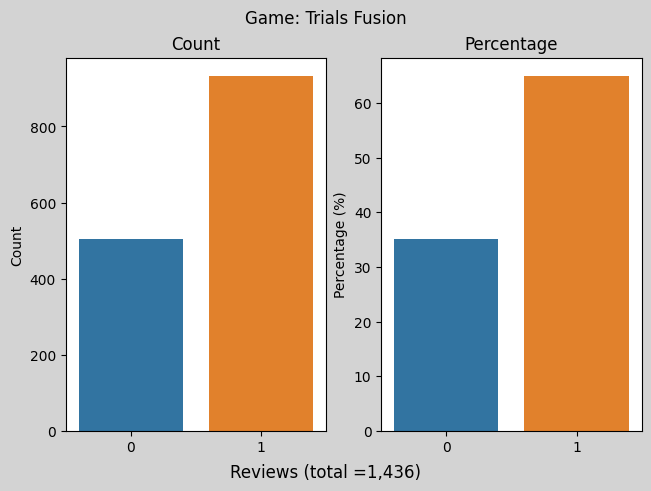

Top 20 most common words in reviews for 'Trials Fusion':

 game   not trial  play    on   get  good   fun track  like  just uplay  time   all   buy    no   one would great  make 
 2073  1004   667   618   597   462   414   392   374   344   339   315   302   299   262   262   244   240   239   230 


This top 20 represents 23.41% or 9,677 out of the 41,340 total frequencies.

While 20 words represents 0.45% out of the total 4,458 unique words.

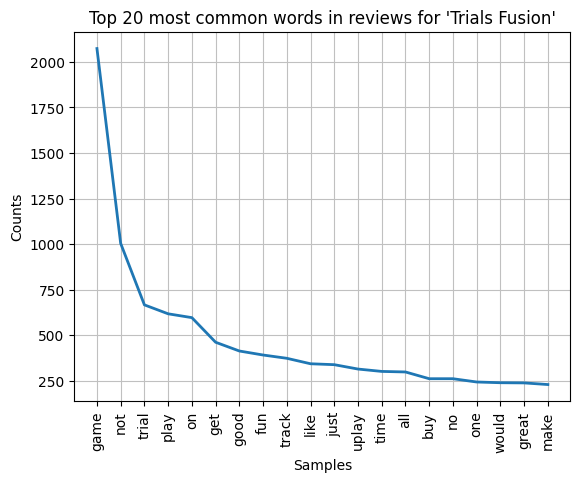

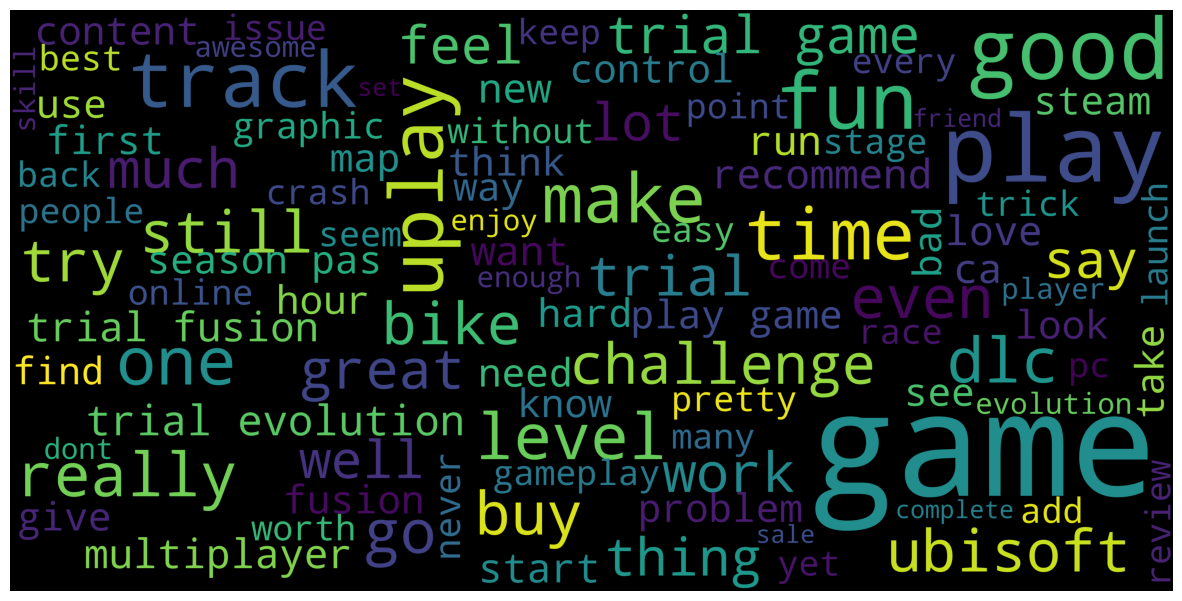

[11/13/24 13:44:19] INFO     Pickle file ./models/logreg_grid.pkl loaded                           ]8;id=820409;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\1792245832.py\1792245832.py]8;;\:]8;id=233986;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\1792245832.py#52\52]8;;\

                    INFO     Pickle file ./models/kneighborsclf_grid.pkl loaded                    ]8;id=779964;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\1792245832.py\1792245832.py]8;;\:]8;id=212342;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\1792245832.py#52\52]8;;\

                    INFO     Pickle file ./models/randomforestclf_grid.pkl loaded                  ]8;id=22570;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\1792245832.py\1792245832.py]8;;\:]8;id=333603;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\1792245832.py#52\52]8;;\

                    INFO     Pickle file ./models/bernoullinb_grid.pkl loaded                      ]8;id=519907;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\1792245832.py\1792245832.py]8;;\:]8;id=472627;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\1792245832.py#52\52]8;;\

                    INFO     Pickle file ./models/gaussiannb_grid.pkl loaded                       ]8;id=515269;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\1792245832.py\1792245832.py]8;;\:]8;id=161351;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\1792245832.py#52\52]8;;\

                    INFO     Pickle file ./models/multinomialnb_grid.pkl loaded                    ]8;id=320619;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\1792245832.py\1792245832.py]8;;\:]8;id=250848;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_13804\1792245832.py#52\52]8;;\

,Metrics,test_accuracy
logreg,0.728,0.728
kneighborsclf,0.775,0.775
randomforestclf,0.705,0.705
bernoullinb,0.734,0.734
gaussiannb,0.689,0.689
multinomialnb,0.768,0.768


Accuracy base line: 0.650

Metrics,accuracy,precision_macro,recall_macro,f1_score_macro,roc_auc,matthews_corrcoef,LR+,LR-,log_loss,brier_score_loss
kneighborsclf,0.775,0.756,0.737,0.744,0.827,0.492,2.208,0.222,0.530,0.177
multinomialnb,0.768,0.780,0.695,0.709,0.857,0.467,1.711,0.135,0.477,0.156
bernoullinb,0.734,0.715,0.671,0.680,0.810,0.383,1.631,0.257,0.926,0.222
logreg,0.728,0.759,0.628,0.627,0.842,0.365,1.365,0.134,0.507,0.169
randomforestclf,0.705,0.689,0.615,0.615,0.759,0.295,1.337,0.271,0.618,0.196
gaussiannb,0.689,0.653,0.637,0.641,0.639,0.290,1.508,0.407,11.147,0.311


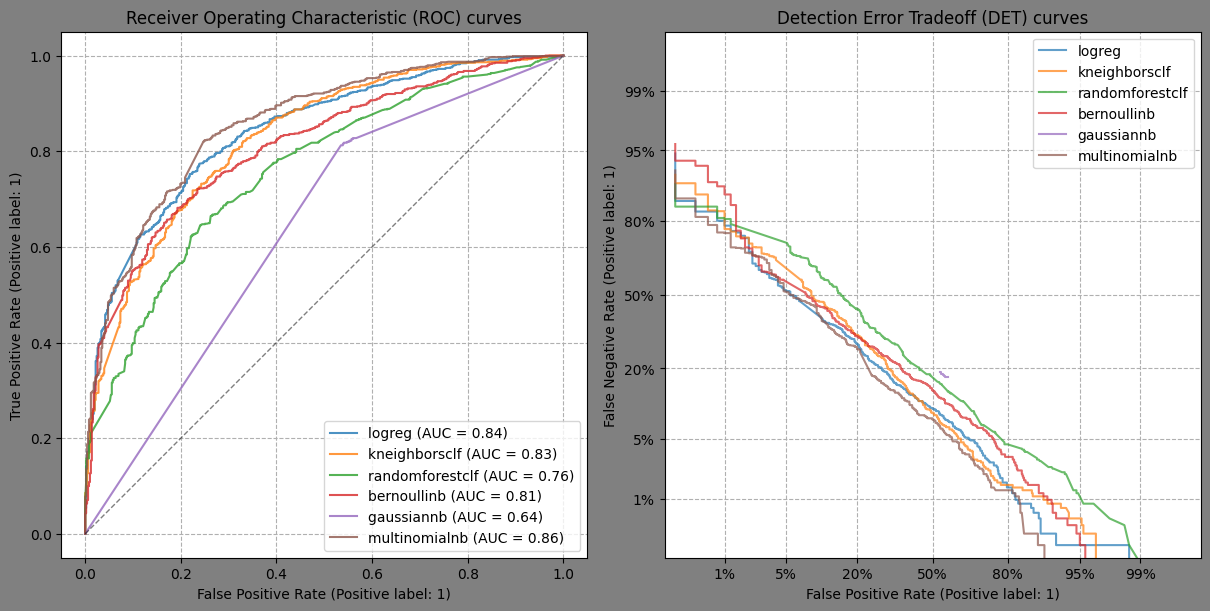

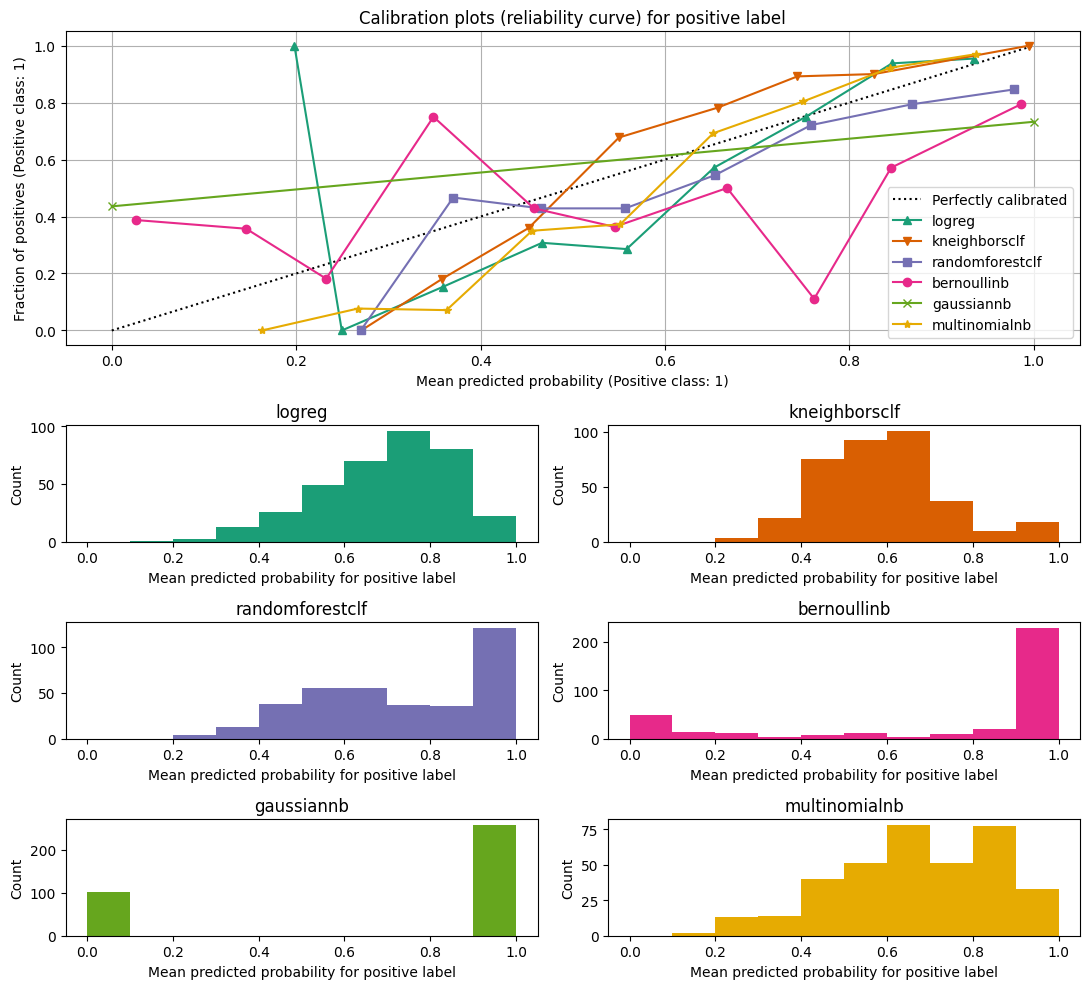

Top Keywords for game:

,Trials Fusion
0,fun
1,good
2,great
3,trial
4,love
5,best
6,awesome
7,1010
8,like
9,nice


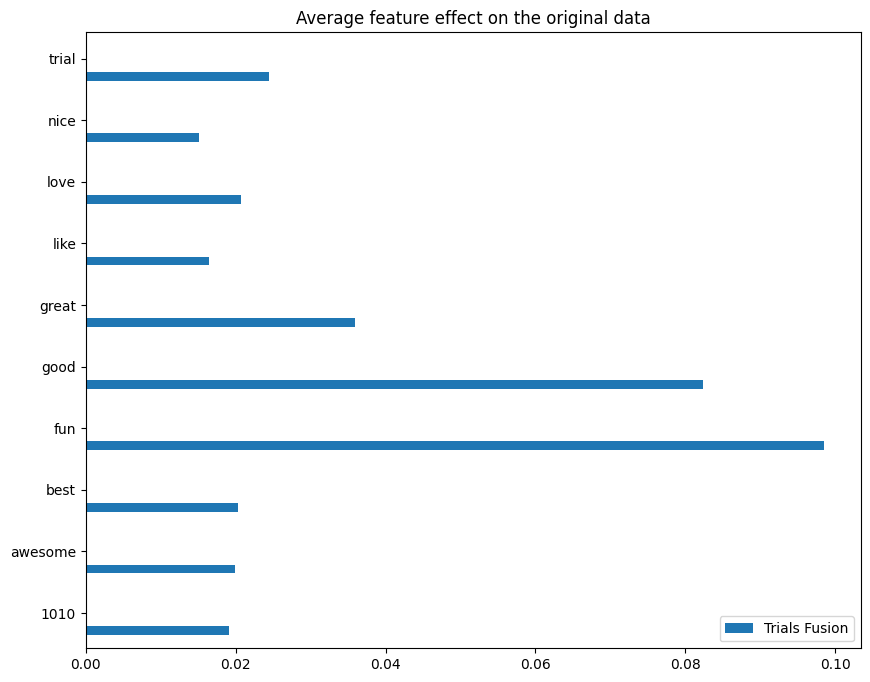

In [120]:
run_all_tasks("Trials Fusion", "245490")
# run_all_tasks("Trials Fusion", "245490", pipeline=[("gaussiannb", gaussiannb_pipeline)])

In [44]:
# game2 = pre_ml_task("Trials Fusion", "245490")
# display('', clear=True)

# clf = load_gridsearchcv_models()
# game2, models_gs, df_metrics = show_metrics_task(game2, use_test_split=False)
# show_roc_det_curves(game2, models_gs, use_test_split=False)

# clf = {"gaussiannb" : train_new(game2, gaussiannb_pipeline)}
# game2, models_gs, df_metrics = show_metrics_task(game2,[], clf, use_test_split=True)
# show_roc_det_curves(game2, clf, use_test_split=True)